In [0]:
from google.colab import drive
drive.mount('/content/drive')

In [0]:
cd drive/My Drive/Colab Notebooks/TOPICS IN APPLIED STATISTICS1/12

In [0]:
import tensorflow.keras
from tensorflow.keras import layers
import numpy as np

latent_dim = 32
height = 32
width = 32
channels = 3


# generator 정의

generator_input = tensorflow.keras.Input(shape=(latent_dim,)) # noise텀을 집어넣음. (z=latent_dim이라 할 때), z ~ N(0,1)


x = layers.Dense(128 * 16 * 16)(generator_input)
x = layers.LeakyReLU()(x) # y=0.3x (x<0) , y=x(x>0) // leakyrelu가 더 수렴을 잘함.
x = layers.Reshape((16, 16, 128))(x)


x = layers.Conv2D(256, 5, padding='same')(x)
x = layers.LeakyReLU()(x)


x = layers.Conv2DTranspose(256, 4, strides=2, padding='same')(x)
x = layers.LeakyReLU()(x)


x = layers.Conv2D(256, 5, padding='same')(x)
x = layers.LeakyReLU()(x)
x = layers.Conv2D(256, 5, padding='same')(x)
x = layers.LeakyReLU()(x)

 
out_g = layers.Conv2D(channels, 7, activation='sigmoid', padding='same')(x) # 각 값들이 0과 1사이로 떨어져야 하므로(이미지), sigmoid를 사용.
generator = tensorflow.keras.models.Model(generator_input, out_g)
generator.summary()

# 중요한건, generator는 compile을 하지 않음. 여기는 반쪽짜리이기 때문. (데이터 생성과 관련한 텀이고, 그 생성된 데이터가 좋은지를 정의하지 않았기 때문임.)

Model: "model_4"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_4 (InputLayer)         (None, 32)                0         
_________________________________________________________________
dense_3 (Dense)              (None, 32768)             1081344   
_________________________________________________________________
leaky_re_lu_10 (LeakyReLU)   (None, 32768)             0         
_________________________________________________________________
reshape_2 (Reshape)          (None, 16, 16, 128)       0         
_________________________________________________________________
conv2d_9 (Conv2D)            (None, 16, 16, 256)       819456    
_________________________________________________________________
leaky_re_lu_11 (LeakyReLU)   (None, 16, 16, 256)       0         
_________________________________________________________________
conv2d_transpose_2 (Conv2DTr (None, 32, 32, 256)       1048

In [0]:
# discriminator 정의

discriminator_input = layers.Input(shape=(height, width, channels)) # 생성된 데이터, 혹은 실제 데이터로부터 평가를 받을꺼임.
x = layers.Conv2D(128, 3)(discriminator_input)
x = layers.LeakyReLU()(x)
x = layers.Conv2D(128, 4, strides=2)(x)
x = layers.LeakyReLU()(x)
x = layers.Conv2D(128, 4, strides=2)(x)
x = layers.LeakyReLU()(x)
x = layers.Conv2D(128, 4, strides=2)(x)
x = layers.LeakyReLU()(x)
x = layers.Flatten()(x)
x = layers.Dropout(0.4)(x)

out_d = layers.Dense(1, activation='sigmoid')(x) # 맞다 틀리다로 학습하려고 sigmoid를 사용함.
# 이로써, loss함수도 정의하는 것이아닌, 학습을 통해 진행됨.

discriminator = tensorflow.keras.models.Model(discriminator_input, out_d)
discriminator.summary()

# clipvalue 는 미분절댓값이 1보다 넘으면, 그걸 1로 만들어라
discriminator_optimizer = tensorflow.keras.optimizers.RMSprop(lr=0.0008, clipvalue=1.0, decay=1e-8)

discriminator.compile(optimizer=discriminator_optimizer, loss='binary_crossentropy') 
# 장전완료

Model: "model_5"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_5 (InputLayer)         (None, 32, 32, 3)         0         
_________________________________________________________________
conv2d_13 (Conv2D)           (None, 30, 30, 128)       3584      
_________________________________________________________________
leaky_re_lu_15 (LeakyReLU)   (None, 30, 30, 128)       0         
_________________________________________________________________
conv2d_14 (Conv2D)           (None, 14, 14, 128)       262272    
_________________________________________________________________
leaky_re_lu_16 (LeakyReLU)   (None, 14, 14, 128)       0         
_________________________________________________________________
conv2d_15 (Conv2D)           (None, 6, 6, 128)         262272    
_________________________________________________________________
leaky_re_lu_17 (LeakyReLU)   (None, 6, 6, 128)         0   

In [0]:
# 1. 구분자를 학습시킨다. (loss를 먼저 학습)
# 2. 생성자를 학습시킨다.

gan_input = tensorflow.keras.Input(shape=(latent_dim,))
img_f=generator(gan_input) 
discriminator.trainable = False # 생성자를 학습시키는 도중엔, 학습을 이미 시켰던 구분자는 추가로 더 학습을 시키면 안 됨. 
# (물론, 생성자 관점에서는 구분자는 학습되지 않지만, 큰 윤곽에서는 동시에 진행되는거임.)

gan_output = discriminator(img_f) # 그렇게 얻은 GAN 결과물의 평가를 받음.  
# 이때 discriminator는 trainable하지 않은 변수임. 그렇게 output을 얻고, 모형을 쌓음.
# 위에서는, trainable하게 한 뒤 모형을 쌓았기 때문에 충돌되지 않음.

# img_f가 discriminator를 통과시키고 나온 결과 tensor를 gan_output이라 함. predict는 model이라고 변수를 정의했으면, 그 안의 method로 value를출력
# discriminator는 Model이고, 그렇기 때문에 tensor와 연결쓸 수 있음.

gan = tensorflow.keras.models.Model(gan_input, gan_output) # 32개짜리 random vector가 들어와서, 하나의 feature value를 내놓게 됨.


gan_optimizer = tensorflow.keras.optimizers.RMSprop(lr=0.0004, clipvalue=1.0, decay=1e-8)
gan.compile(optimizer=gan_optimizer, loss='binary_crossentropy') # gan 자체는 binary_crossentropy로 평가함. 당연함. 마지막에 discriminator 가 있기 때문.
# 장전

gan.summary()

# GAN은 이렇게 학습.


Model: "model_6"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_6 (InputLayer)         (None, 32)                0         
_________________________________________________________________
model_4 (Model)              (None, 32, 32, 3)         6264579   
_________________________________________________________________
model_5 (Model)              (None, 1)                 790913    
Total params: 7,055,492
Trainable params: 6,264,579
Non-trainable params: 790,913
_________________________________________________________________


In [0]:
import os
from tensorflow.keras.preprocessing import image

# Load CIFAR10 data
(x_train, y_train), (_, _) = tensorflow.keras.datasets.cifar10.load_data()

# Select frog images (class 6)
x_train = x_train[y_train.flatten() == 6]  # 6번만 가지고 학습(개구리형상)

x_train = x_train.reshape(
    (x_train.shape[0],) + (height, width, channels)).astype('float32') / 255. 
    # 이렇게하면, (5000,) + (32,32,3) -> (5000,32,32,3) 이 완성됨.

x_train.shape

(5000, 32, 32, 3)

In [0]:
(2,3,3,)+(10,10,10)

(2, 3, 3, 10, 10, 10)

In [18]:
# labeling을 통해 마치 지도학습처럼 학습시킴. (맞다 틀리다의 labeling)

# 16만번이므로, 32epoch정도가 됨. (데이터수가 5천)
# batch단위로 training을 시킴.

iterations = 8000
batch_size = 20

start = 0
for step in range(iterations):  # 반복수 8천
    
    random_latent_vectors = np.random.normal(size=(batch_size, latent_dim)) # 20 x latent dim(=32) 으로 구성.
    generated_images = generator.predict(random_latent_vectors) # 이미지생성

    stop = start + batch_size # 데이터를 이만큼씩 학습할거임.
    real_images = x_train[start :stop]
    combined_images = np.concatenate([real_images, generated_images]) # 진짜이미지와, 생성된 이미지를 평가. 데이터 수 방향으로 합침. (default: axis = 0)

   
    y= np.concatenate([np.ones((batch_size, 1)), # 마찬가지로 맞는이미지, 틀린 이미지라는 의미의 labeling이 진행됨. 진짜 이미지에 대해선 1, 가짜 이미지에 대해선 0 임.
                             np.zeros((batch_size, 1))]) # 이 입장은 구분자(discriminator)의 학습에서 진행되는거임. 데이터 수 방향으로 합침.
   
    y += 0.05 * np.random.random(y.shape) 
    # 학습을 더 빠르게(?) 시키려고 살짝 trick을 진행함.
    # y shape만큼 uniform 난수를 생성. 1/20을 하는 이유는, 배치사이즈만큼 나눠준거임(추측). 그만큼 변동을 줌...? label 을 흔들려고 그러나... label smoothing과 유사한거 같은데..

    # Train the discriminator
    d_loss = discriminator.train_on_batch(combined_images,y) # 그냥 , fit이나 fit_generator대신에 사용하는 것으로, 딱 batch_size만큼만 train하고 싶을때 사용함.
    # 이걸 학습을 시킨다. return값은 score임. 
    # batch_size만큼 scoring을 함.
    # 여기 부분이 fitting임. 구분자 먼저 학습. 
    # Scalar training loss (if the model has a single output and no metrics) or list of scalars (if the model has multiple outputs and/or metrics). 
    # The attribute model.metrics_names will give you the display labels for the scalar outputs.
    # accruacy같은 측도가 없을때, loss를 반환함.


    # sample random points in the latent space
    random_latent_vectors = np.random.normal(size=(batch_size, latent_dim)) # size만큼 N(0,1)에서 난수 생성. 

    # Assemble labels that say "all real images"
    misleading_targets = np.ones((batch_size, 1)) # label을 1로 할당. generator기준에서는, 모두다 맞는거임. 

    # Train the generator (via the gan model,
    # where the discriminator weights are frozen)
    a_loss = gan.train_on_batch(random_latent_vectors, misleading_targets) # 그렇게 역시나 scoring
    # 다시말함. 여기 부분이 fitting임. GAN 나중에 학습. / GAN loss를 뽑음.


    # 주의할것은, a_loss와 d_loss는 섞이지 않는다.


    start += batch_size # start는 갱신.
    if start > len(x_train) - batch_size: # start > 4980 - > 5천개 학습했으므로(4980 > 4980은 아니기 때문에, start=0을 선택안함. 5000> 4980이 되는 순간에 start=0), 다시 0부터 초기화.
      start = 0

    # Occasionally save / plot
    if (step+1) % 1000 == 0: # 1000으로 나눈나머지가 0이면, 프린트.
        # Print metrics
        print('discriminator loss at step %s: %s' % ((step+1), d_loss))
        print('adversarial loss at step %s: %s' % ((step+1), a_loss))       
        
# loss 결과를 보면, 변동이 거의 없는것 처럼 보임.
# 굉장히 어렵다는 의미임.
# 8천번 밖에 못돌려봤지만, 8만번은 돌려야 수렴하는지를 알게됨.


discriminator loss at step 1000: 0.685228168964386
adversarial loss at step 1000: 0.6457014083862305
discriminator loss at step 2000: 0.6910989880561829
adversarial loss at step 2000: 0.6385136246681213
discriminator loss at step 3000: 0.6969332695007324
adversarial loss at step 3000: 0.6298547387123108
discriminator loss at step 4000: 0.6942012906074524
adversarial loss at step 4000: 0.7123216390609741
discriminator loss at step 5000: 0.674202024936676
adversarial loss at step 5000: 0.30841514468193054
discriminator loss at step 6000: 0.7023888230323792
adversarial loss at step 6000: 0.6416942477226257
discriminator loss at step 7000: 0.6845546960830688
adversarial loss at step 7000: 0.6469212174415588
discriminator loss at step 8000: 0.6888977885246277
adversarial loss at step 8000: 0.6230242252349854
discriminator loss at step 9000: 0.6957899332046509
adversarial loss at step 9000: 0.6523857712745667
discriminator loss at step 10000: 0.6961028575897217
adversarial loss at step 10000

In [19]:
len(x_train)-batch_size

4980

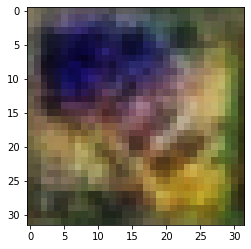

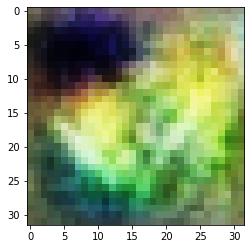

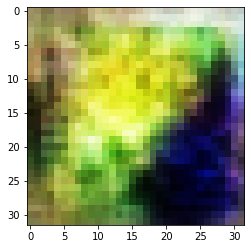

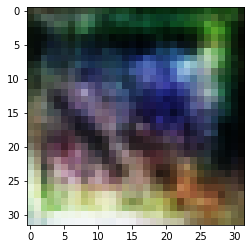

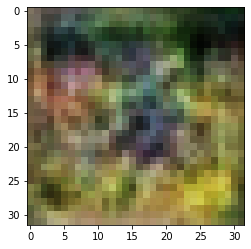

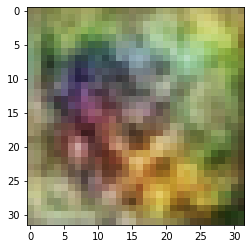

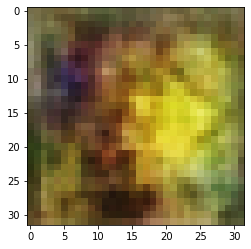

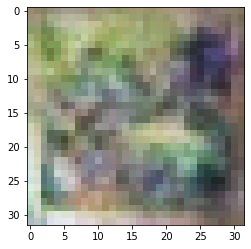

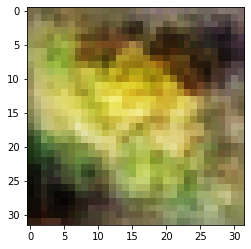

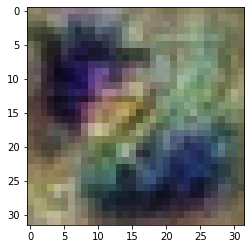

In [20]:
import matplotlib.pyplot as plt
from tensorflow.keras.preprocessing import image

random_latent_vectors = np.random.normal(size=(10, latent_dim))

generated_images = generator.predict(random_latent_vectors) # 생성자로부터 10개 끄집어냄.

for i in range(generated_images.shape[0]):
    img = image.array_to_img(generated_images[i] * 255., scale=False) #
    plt.figure()
    plt.imshow(img)
    
plt.show()

# 그림을 보지만, 개구리 같지가 않다.
# 2016년쯤에 나왔고, 굉장히 잘 되지 않는다. 
# 일반적으로 GAN이라고 하면 이 모형을 얘기하고, 거의 수렴하지 않음
# 모형을 바꾸든지 해야하는데, 좀 바꾸면 잘 되지도 않는다.

# 이 내용은 keras창시자가 2018년에 쓴 책을 고스란히 코드로 가져온 내용.
